# Mass Identification with B8 Background

## Import packages and define functions

In [1]:
import ROOT
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import scipy.interpolate as ip
from matplotlib.ticker import MultipleLocator
from scipy.stats import poisson
from scipy import interpolate
import uproot
import glob

Welcome to JupyROOT 6.20/04


Tip: 

to check headers in RooArgSet: row.Print()

In [128]:
#from https://gitlab.com/luxzeplin/stats/LowE_NR_group/-/blob/master/notebooks/modules/LZBANDS.py#L230
def read_data_from_RooDataSet(file_path, object_name):
    ''' 
    Read data from a ROOT.RooDataSet object
    '''
    f = ROOT.TFile(file_path)
    dataset = f.Get(object_name)
    nSamples = int(dataset.sumEntries())
    X = np.zeros(nSamples, dtype=float) 
    Y = np.zeros(nSamples, dtype=float)
    for i in range(nSamples):
        row = dataset.get(i)
        X[i] = row.getRealValue('S1')
        Y[i] = row.getRealValue('log_S2')

    f.Close()
    return X,Y


In [129]:
#some uproot
def read_histogram(file_name):
    root_model_file = uproot.open(file_name)
    values, xEdges, yEdges = root_model_file['h_S1logS2'].to_numpy()
    return values,xEdges,yEdges

In [130]:
#mean_background_count: scalar, mean background count per cell (after scaled with the scaling ratio returned by get_scaling_ratio)
#mean_signal_count: scalar, mean signal count per cell (after scaled with the scaling ratio returned by get_scaling_ratio)
#observed_count: scalar, observed count per cell
#return: P(n|mu)
#called in other functions
#Eq 3.2 from Feldman and Cousins

def get_poisson_probability(mean_background_count, mean_signal_count, observed_count):
    return poisson.pmf(observed_count, mean_background_count+mean_signal_count)
    #poission_probability = (mean_signal_count+mean_background_count)**observed_count*np.exp(-(mean_signal_count+mean_background_count))/(np.math.factorial(n))

In [131]:
#expected_count: scalar. 21 for background; 50 for signal
#called in other functions
def get_scaling_ratio(histogram_values, expected_count):
    total_histogram_count = np.sum(histogram_values) #sum over all the elements in the matrix
    return expected_count/total_histogram_count

In [132]:
#store the read histogram to save time (trading time with affordable space)
def read_model_histograms(model_name_list):
    values_list = []
    xEdges_list = []
    yEdges_list = []
    for model_name in model_name_list:
        values, xEdges, yEdges = read_histogram(model_name)
        values_list.append(values)
        xEdges_list.append(xEdges)
        yEdges_list.append(yEdges)
        
    return values_list,xEdges_list,yEdges_list

In [133]:
def get_interpolating_function(xEdges,yEdges,sig_pdf_matrix,scaling_ratio_sig,bg_pdf_matrix,scaling_ratio_bg):
    x_bin_size = xEdges[1]-xEdges[0]
    xCenters = xEdges[:-1]+x_bin_size/2
    
    y_bin_size = yEdges[1]-yEdges[0]
    yCenters = yEdges[:-1]+y_bin_size/2
    
    #interpolating_function_sig = interpolate.interp2d(xCenters,yCenters,sig_pdf_matrix)
    #interpolating_function_bg = interpolate.interp2d(xCenters,yCenters,bg_pdf_matrix)
    
    summed_pdf_matrix = np.zeros((len(xEdges)-1,len(yEdges)-1))
    for S1_index in range(len(xEdges)-1):
        for S2_index in range(len(yEdges)-1):
            summed_pdf_matrix[S1_index][S2_index] = scaling_ratio_sig*sig_pdf_matrix[S1_index][S2_index]+scaling_ratio_bg*bg_pdf_matrix[S1_index][S2_index]
    return interpolate.interp2d(xCenters,yCenters,summed_pdf_matrix)
#scaling_ratio_sig*interpolating_function_sig+scaling_ratio_bg*interpolating_function_bg

In [134]:
#interpolating_function: returned from get_interpolating_function
#S1_value,logS2_value: scalars, the S1 and S2 value of one data point
def get_likelihood(interpolating_function,S1_value,logS2_value):
    return interpolating_function(S1_value,logS2_value)

In [176]:
#returns the poisson probability matrix
#value_list is the list of mass values
def get_likelihood_list(value_list,background_file_path, background_file_name, data_file_path, data_object_name):
    S1_value_data,logS2_value_data = read_data_from_RooDataSet(data_file_path,data_object_name)
    expected_sig_count = 50.
    expected_bg_count = 20.66
    expected_total_count = expected_sig_count+expected_bg_count
    value_bg, xEdges_bg, yEdges_bg = read_histogram(background_file_path+background_file_name)
    scaling_ratio_bg = get_scaling_ratio(value_bg,expected_bg_count/expected_total_count)
    summed_likelihood_list = []
    for mass_index in range(len(value_list)): #variable to fit
        total_likelihood = 0.
        print(mass_index)
        scaling_ratio_sig = get_scaling_ratio(value_list[mass_index],expected_sig_count/expected_total_count)
        interpolating_function = get_interpolating_function(xEdges_bg,yEdges_bg,value_list[mass_index],scaling_ratio_sig,value_bg,scaling_ratio_bg)
        for i in range(len(S1_value_data)):
            likelihood = get_likelihood(interpolating_function,S1_value_data[i],logS2_value_data[i])
            if likelihood > 0.:
                total_likelihood = total_likelihood+np.log(likelihood)
        summed_likelihood_list.append(total_likelihood)
    return np.array(summed_likelihood_list)

In [136]:
#final method
#identify the fitted parameters: mass and expected count
#R_matrix_summed is an np.ndarray from get_R
#the np array argmax documentation is more complicated than coding it myself
def get_fitted_parameters(PLR_array):
    max_PLR = np.amax(PLR_array) #initialization
    max_index_list = [] #list of mass_index
    #find the mass_index with the maximum R value (max_R)
    for mass_index in range(len(PLR_array)):
        if PLR_array[mass_index] == max_PLR:
            max_index_list.append(mass_index)
    return np.array(max_index_list)

## Define file names

In [137]:
model_path = '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/'
model_names = glob.glob(model_path+'/wimp_pdf_*.root')
print(model_names)

['/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m11.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m508.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m1420.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m40.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m16.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m716.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m32.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m361.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m1008.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m2000.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m129.root', '/global/cfs/cdirs/lz/data/LZSta

In [138]:
data_file_path = '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/mysterious_data/mock_data_n76.root'
data_object_name = 'obs_data'

background_file_path = '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/'
background_file_name = 'background_pdf_8B.root'

## Fitting

In [190]:
#load model pdfs for wimps with different mass
model_value_list,model_xEdges_list,model_yEdges_list = read_model_histograms(model_names)

In [191]:
likelihood_list = get_likelihood_list(model_value_list,background_file_path, background_file_name, data_file_path, data_object_name)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [192]:
fitted_parameters = get_fitted_parameters(likelihood_list)

In [193]:
for i in range(len(fitted_parameters)):
    print(model_names[fitted_parameters[i]])

/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m5.root


## 68.3% CL interval

In [194]:
likelihood_list

array([[-44.57295766],
       [-48.1047    ],
       [-51.01489532],
       [-98.00585174],
       [-61.03879   ],
       [-39.97726168],
       [-66.27565163],
       [-35.06458203],
       [-66.38181523],
       [-36.17470266],
       [-54.67306695],
       [-18.61479374],
       [-80.81055543],
       [-57.42868493],
       [-54.91522803],
       [-82.39556557],
       [-63.99395664],
       [-64.55629492],
       [-52.03623466]])

## Construction zone

In [180]:
expected_sig_count = 50.
expected_bg_count = 20.66
expected_total_count = expected_sig_count+expected_bg_count

In [181]:
value_bg, xEdges_bg, yEdges_bg = read_histogram(background_file_path+background_file_name)

In [182]:
scaling_ratio_bg = get_scaling_ratio(value_bg,expected_bg_count/expected_total_count)

In [183]:
mass_index = 9

In [184]:
x_bin_size = xEdges_bg[1]-xEdges_bg[0]
xCenters = xEdges_bg[:-1]+x_bin_size/2
    
y_bin_size = yEdges_bg[1]-yEdges_bg[0]
yCenters = yEdges_bg[:-1]+y_bin_size/2
    
    
summed_pdf_matrix = np.zeros((len(xEdges_bg)-1,len(yEdges_bg)-1))
for S1_index in range(len(xEdges_bg)-1):
    for S2_index in range(len(yEdges_bg)-1):
        summed_pdf_matrix[S1_index][S2_index] = scaling_ratio_sig*model_value_list[mass_index][S1_index][S2_index]+scaling_ratio_bg*value_bg[S1_index][S2_index]
#test_model_interpolating_function = interpolate.interp2d(xCenters,yCenters,summed_pdf_matrix)

In [185]:
scaling_ratio_sig = get_scaling_ratio(model_value_list[mass_index],expected_sig_count/expected_total_count)

In [186]:
test_model_interpolating_function = get_interpolating_function(xEdges_bg,yEdges_bg,model_value_list[mass_index],scaling_ratio_sig,value_bg,scaling_ratio_bg)


In [187]:
znew = test_model_interpolating_function(xCenters,yCenters)

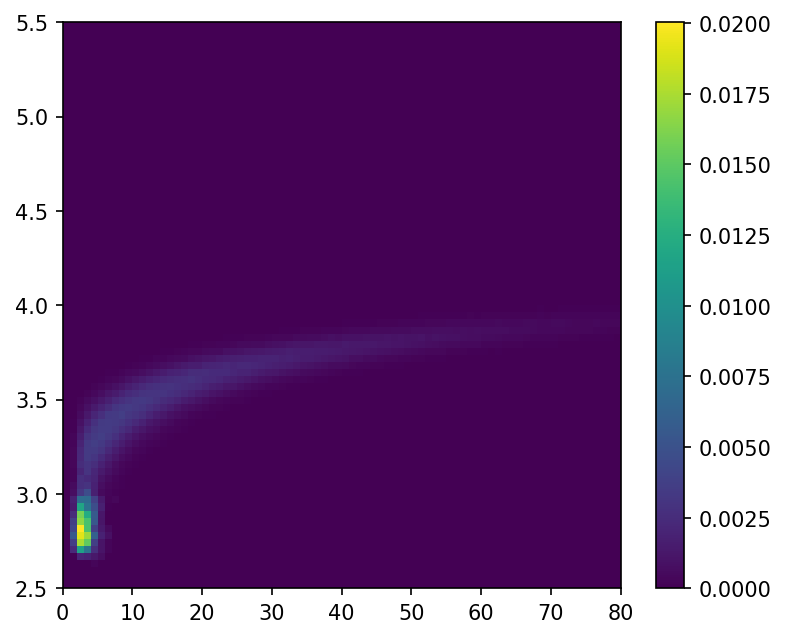

In [188]:
fig, ax = plt.subplots(dpi=150, figsize=(6,5))
pcm = ax.pcolormesh(xEdges_bg,yEdges_bg,np.transpose(summed_pdf_matrix), zorder=1)
cbar = fig.colorbar(pcm)

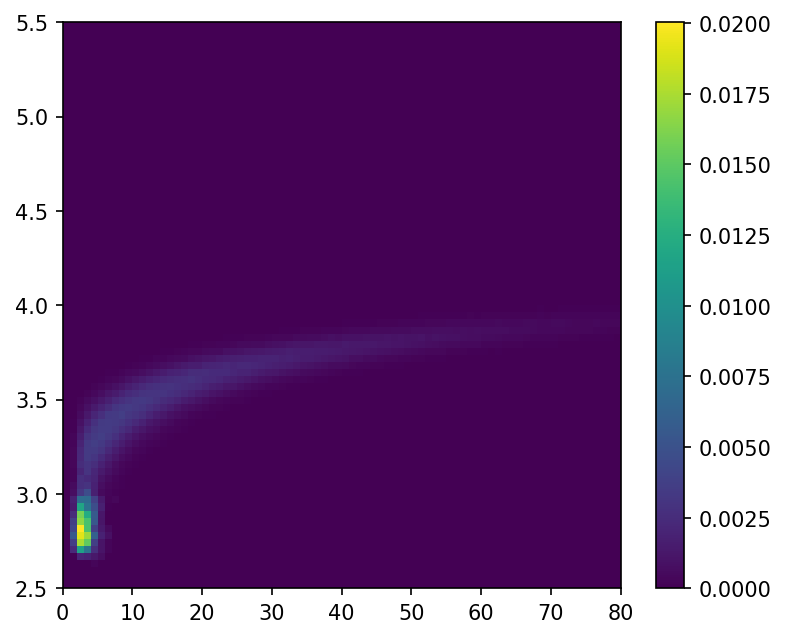

In [189]:
fig, ax = plt.subplots(dpi=150, figsize=(6,5))
pcm = ax.pcolormesh(xEdges_bg,yEdges_bg,np.transpose(znew), zorder=1)
cbar = fig.colorbar(pcm)